<a href="https://www.kaggle.com/code/lucasaresin/nobody-knows-is-movie-success-unknowable?scriptVersionId=146272267" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Nobody knows
A principle in many creative industries is the 'nobody knows' principle, also known as demand uncertainty, which expresses the inability to predict a product's success at the box office because it is very difficult to predict which combination of factors will result in a product that people want. At first glance, it seems intuitively correct: Big movies with star power and a marketing war machine can fail miserably, while obscure independent projects suddenly rise unexpectedly with viral intensity.

Can big data / data science help us to confirm / disprove this idea? And how close can you get to predicting a movie's box office success?

# Feature selection
In reality, when we want to predict a movie's success, we want to do it before the movie releases, or ideally before it is green-lit. As such we have to confine ourselves to data that we would have prior to release. For example, user ratings might be a great predictor, but not something available to us before we decide if we want to finance a project.

# Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
from tqdm import tqdm
from regex import regex
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor

sns.set()

In [2]:
movies_metadata = pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv', low_memory = False)
credits = pd.read_csv('/kaggle/input/the-movies-dataset/credits.csv', low_memory = False)
keywords = pd.read_csv('/kaggle/input/the-movies-dataset/keywords.csv', low_memory = False)
# links = pd.read_csv('/kaggle/input/the-movies-dataset/links.csv', low_memory = False)
# links_small = pd.read_csv('/kaggle/input/the-movies-dataset/links_small.csv', low_memory = False)
# ratings = pd.read_csv('/kaggle/input/the-movies-dataset/ratings.csv', low_memory = False)
# ratings_small = pd.read_csv('/kaggle/input/the-movies-dataset/ratings_small.csv', low_memory = False)

In [3]:
movies_metadata.shape

(45466, 24)

# Features we would know before release

Let's get all columns first so we can decide what we would and wouldn't know beforehand:

In [4]:
movies_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

| Column | Knowledge |
|-|-|
| 'adult' | |
| 'belongs_to_collection' | |
|'budget' | |
| 'genres' | |
| 'homepage' | drop |
| 'id' | drop |
| 'imdb_id' | drop |
| 'original_language' | |
| 'original_title' | drop |
| 'overview' | drop |
| 'popularity' | drop |
| 'poster_path' | drop |
| 'production_companies' | |
| 'production_countries' | |
| 'release_date' | year only |
| 'revenue' | target |
| 'runtime' | |
| 'spoken_languages' | |
| 'status' | |
| 'tagline' | drop |
| 'title' | drop |
| 'video' | drop |
| 'vote_average' | drop |
| 'vote_count' | drop |

In [5]:
pre_release_features = [
    'id',
    'adult',
    'belongs_to_collection',
    'budget',
    'genres',
    'original_language',
    'production_companies',
    'production_countries',
    'release_date',
    'runtime',
    'spoken_languages',
    'status',
    'revenue'
]

movies_df = movies_metadata[pre_release_features].copy()

In [6]:
movies_df.head()

,id,adult,belongs_to_collection,budget,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,revenue
0,862,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,373554033.0
1,8844,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,262797249.0
2,15602,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,0.0
3,31357,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,81452156.0
4,11862,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",en,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,76578911.0


# Remove null values
The remaining columns might contain null values, so let's check!

In [7]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     45466 non-null  object 
 1   adult                  45466 non-null  object 
 2   belongs_to_collection  4494 non-null   object 
 3   budget                 45466 non-null  object 
 4   genres                 45466 non-null  object 
 5   original_language      45455 non-null  object 
 6   production_companies   45463 non-null  object 
 7   production_countries   45463 non-null  object 
 8   release_date           45379 non-null  object 
 9   runtime                45203 non-null  float64
 10  spoken_languages       45460 non-null  object 
 11  status                 45379 non-null  object 
 12  revenue                45460 non-null  float64
dtypes: float64(2), object(11)
memory usage: 4.5+ MB


In [8]:
def check_for_nulls(dataframe):
    return dataframe.isna().sum().sort_values(ascending=False)

In [9]:
check_for_nulls(movies_df)

belongs_to_collection    40972
runtime                    263
release_date                87
status                      87
original_language           11
spoken_languages             6
revenue                      6
production_companies         3
production_countries         3
id                           0
adult                        0
budget                       0
genres                       0
dtype: int64

In [10]:
movies_df[movies_df['spoken_languages'].isna()]

,id,adult,belongs_to_collection,budget,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,revenue
19729,82663,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",en,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19730,1997-08-20,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...",104.0,False,6.0,1,NaN,NaN,NaN,NaN
29502,122662,False,"{'id': 122661, 'name': 'Mardock Scramble Colle...",0,"[{'id': 16, 'name': 'Animation'}, {'id': 878, ...",ja,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,2012-09-29,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...",68.0,False,7.0,12,NaN,NaN,NaN,NaN
35586,249260,False,NaN,0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 28,...",en,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,2014-01-01,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...",82.0,False,4.3,22,NaN,NaN,NaN,NaN


In [11]:
movies_df[movies_df['production_companies'].isna()]

,id,adult,belongs_to_collection,budget,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,revenue
19729,82663,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",en,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29502,122662,False,"{'id': 122661, 'name': 'Mardock Scramble Colle...",0,"[{'id': 16, 'name': 'Animation'}, {'id': 878, ...",ja,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35586,249260,False,NaN,0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 28,...",en,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
movies_df[movies_df['runtime'].isna()]

,id,adult,belongs_to_collection,budget,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,revenue
634,287305,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",de,"[{'name': 'Westdeutscher Rundfunk (WDR)', 'id'...","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",1996-03-21,NaN,[],Released,0.0
635,339428,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",de,"[{'name': 'Senator Film Produktion', 'id': 191}]","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",1996-03-14,NaN,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,65335.0
644,278978,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",de,[],"[{'iso_3166_1': 'DE', 'name': 'Germany'}]",1996-02-29,NaN,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,0.0
802,282919,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",de,[],"[{'iso_3166_1': 'DE', 'name': 'Germany'}]",1996-06-20,NaN,[],Released,0.0
863,253632,False,NaN,0,"[{'id': 53, 'name': 'Thriller'}]",fr,[],[],1988-10-08,NaN,[],Released,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45246,231216,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",de,[],"[{'iso_3166_1': 'AT', 'name': 'Austria'}, {'is...",2004-12-02,NaN,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,0.0
45310,418757,False,NaN,0,[],pl,[],[],2014-08-01,NaN,[],Released,0.0
45313,369444,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",pl,[],"[{'iso_3166_1': 'PL', 'name': 'Poland'}]",1989-10-27,NaN,[],Released,0.0
45377,317389,False,NaN,0,"[{'id': 12, 'name': 'Adventure'}]",es,"[{'name': 'Roas Produzioni', 'id': 21137}, {'n...","[{'iso_3166_1': 'IT', 'name': 'Italy'}]",1973-07-22,NaN,"[{'iso_639_1': 'it', 'name': 'Italiano'}]",Released,0.0


Let's see what we can do about the missing values. Looking at the overall analysis, with one exception, all features missing data each cover less than 0.5 % of total observations, so we can probably drop them entirely and save us some time.

| Column | Knowledge |
|-|-|
| 'belongs_to_collection' | Here, the 'missing values' are simple np.nan values wherever the movie does not belong to a collection. To simplify, we turn this into a boolean category, where NaN -> 0, and not NaN -> 1 |
| 'original_language' | Drop |
| 'production_companies' | Drop |
| 'production_countries' | Drop |
| 'release_date' | Drop |
| 'revenue' | Drop |
| 'runtime' | Drop |
| 'spoken_languages' | Drop |
| 'status' | Drop |

While inspecting the columns with missing values, we notice that some data is messed up, for example in index 19730, the 'adult' column contains some text. That cannot be right and we will have to deal with it.

In [13]:
nan_to_drop = [
    'original_language',
    'production_companies',
    'production_countries',
    'release_date',
    'revenue',
    'runtime',
    'spoken_languages',
    'status'
]

indices_to_drop = []

for nan in nan_to_drop:
    iter_indices = [x for x in movies_df[movies_df[nan].isna()].index]
    for index in iter_indices:
        indices_to_drop.append(index)
    
indices_to_drop_no_duplicates = list(set(indices_to_drop))

movies_df = movies_df.drop(indices_to_drop_no_duplicates,axis=0).copy()
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45043 entries, 0 to 45465
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     45043 non-null  object 
 1   adult                  45043 non-null  object 
 2   belongs_to_collection  4479 non-null   object 
 3   budget                 45043 non-null  object 
 4   genres                 45043 non-null  object 
 5   original_language      45043 non-null  object 
 6   production_companies   45043 non-null  object 
 7   production_countries   45043 non-null  object 
 8   release_date           45043 non-null  object 
 9   runtime                45043 non-null  float64
 10  spoken_languages       45043 non-null  object 
 11  status                 45043 non-null  object 
 12  revenue                45043 non-null  float64
dtypes: float64(2), object(11)
memory usage: 4.8+ MB


In [14]:
# If a movie is part of a collection, 'belongs_to_collection' will be a 1, otherwise a 0
movies_df['collection'] = movies_df['belongs_to_collection'].apply(lambda x: 0 if pd.isna(x) else 1 if isinstance(x, str) else 0).tolist()
movies_df = movies_df.drop('belongs_to_collection',axis=1).copy()

In [15]:
check_for_nulls(movies_df)

id                      0
adult                   0
budget                  0
genres                  0
original_language       0
production_companies    0
production_countries    0
release_date            0
runtime                 0
spoken_languages        0
status                  0
revenue                 0
collection              0
dtype: int64

# Cast columns are correct datatypes

In [16]:
type_dict = {
    'adult':'category',
    'budget':'int32',
    'genres':'string',
    'original_language':'category',
    'production_companies':'string',
    'production_countries':'string',
    'runtime':'int32',
    'spoken_languages':'string',
    'status':'category',
    'revenue':'int64',
    'collection':'int16'
}

In [17]:
# cast columns as data types and show me where that fails

for i, term in enumerate(type_dict):
    try:
        movies_df[term] = movies_df[term].astype(type_dict[term])
    except:
        print(i, term)

Seems like removing the missing values also took care of the problematic data. Great!

In [18]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45043 entries, 0 to 45465
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    45043 non-null  object  
 1   adult                 45043 non-null  category
 2   budget                45043 non-null  int32   
 3   genres                45043 non-null  string  
 4   original_language     45043 non-null  category
 5   production_companies  45043 non-null  string  
 6   production_countries  45043 non-null  string  
 7   release_date          45043 non-null  object  
 8   runtime               45043 non-null  int32   
 9   spoken_languages      45043 non-null  string  
 10  status                45043 non-null  category
 11  revenue               45043 non-null  int64   
 12  collection            45043 non-null  int16   
dtypes: category(3), int16(1), int32(2), int64(1), object(2), string(4)
memory usage: 3.3+ MB


# Deal with categorical data in strings
The columns **genres**, **production_companies** and **spoken_languages** are encoded in json-like lists. We want to turn those into actual lists so we may use them later.

In [19]:
literal_eval = lambda x: [x['name'] for x in ast.literal_eval(x)]
movies_df['genre_name'] = movies_df['genres'].apply(literal_eval)
movies_df['prod_comp_names'] = movies_df['production_companies'].apply(literal_eval)

literal_eval_lang = lambda x: [x['iso_639_1'] for x in ast.literal_eval(x)]
movies_df['lang'] = movies_df['spoken_languages'].apply(literal_eval_lang)

In [20]:
movies_df = movies_df.drop(['genres','production_companies','production_countries','spoken_languages','original_language'],axis=1).copy()

Dead with the release date column:

In [21]:
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'])
movies_df['year'] = movies_df['release_date'].dt.year
movies_df['month'] = movies_df['release_date'].dt.month
movies_df = movies_df.drop('release_date',axis=1).copy()

In [22]:
movies_df['adult'] = movies_df['adult'].apply(lambda x: 0 if x == False else 1)
movies_df.head()

,id,adult,budget,runtime,status,revenue,collection,genre_name,prod_comp_names,lang,year,month
0,862,1,30000000,81,Released,373554033,1,"[Animation, Comedy, Family]",[Pixar Animation Studios],[en],1995,10
1,8844,1,65000000,104,Released,262797249,0,"[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...","[en, fr]",1995,12
2,15602,1,0,101,Released,0,1,"[Romance, Comedy]","[Warner Bros., Lancaster Gate]",[en],1995,12
3,31357,1,16000000,127,Released,81452156,0,"[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],[en],1995,12
4,11862,1,0,106,Released,76578911,1,[Comedy],"[Sandollar Productions, Touchstone Pictures]",[en],1995,2


# Preliminary analysis

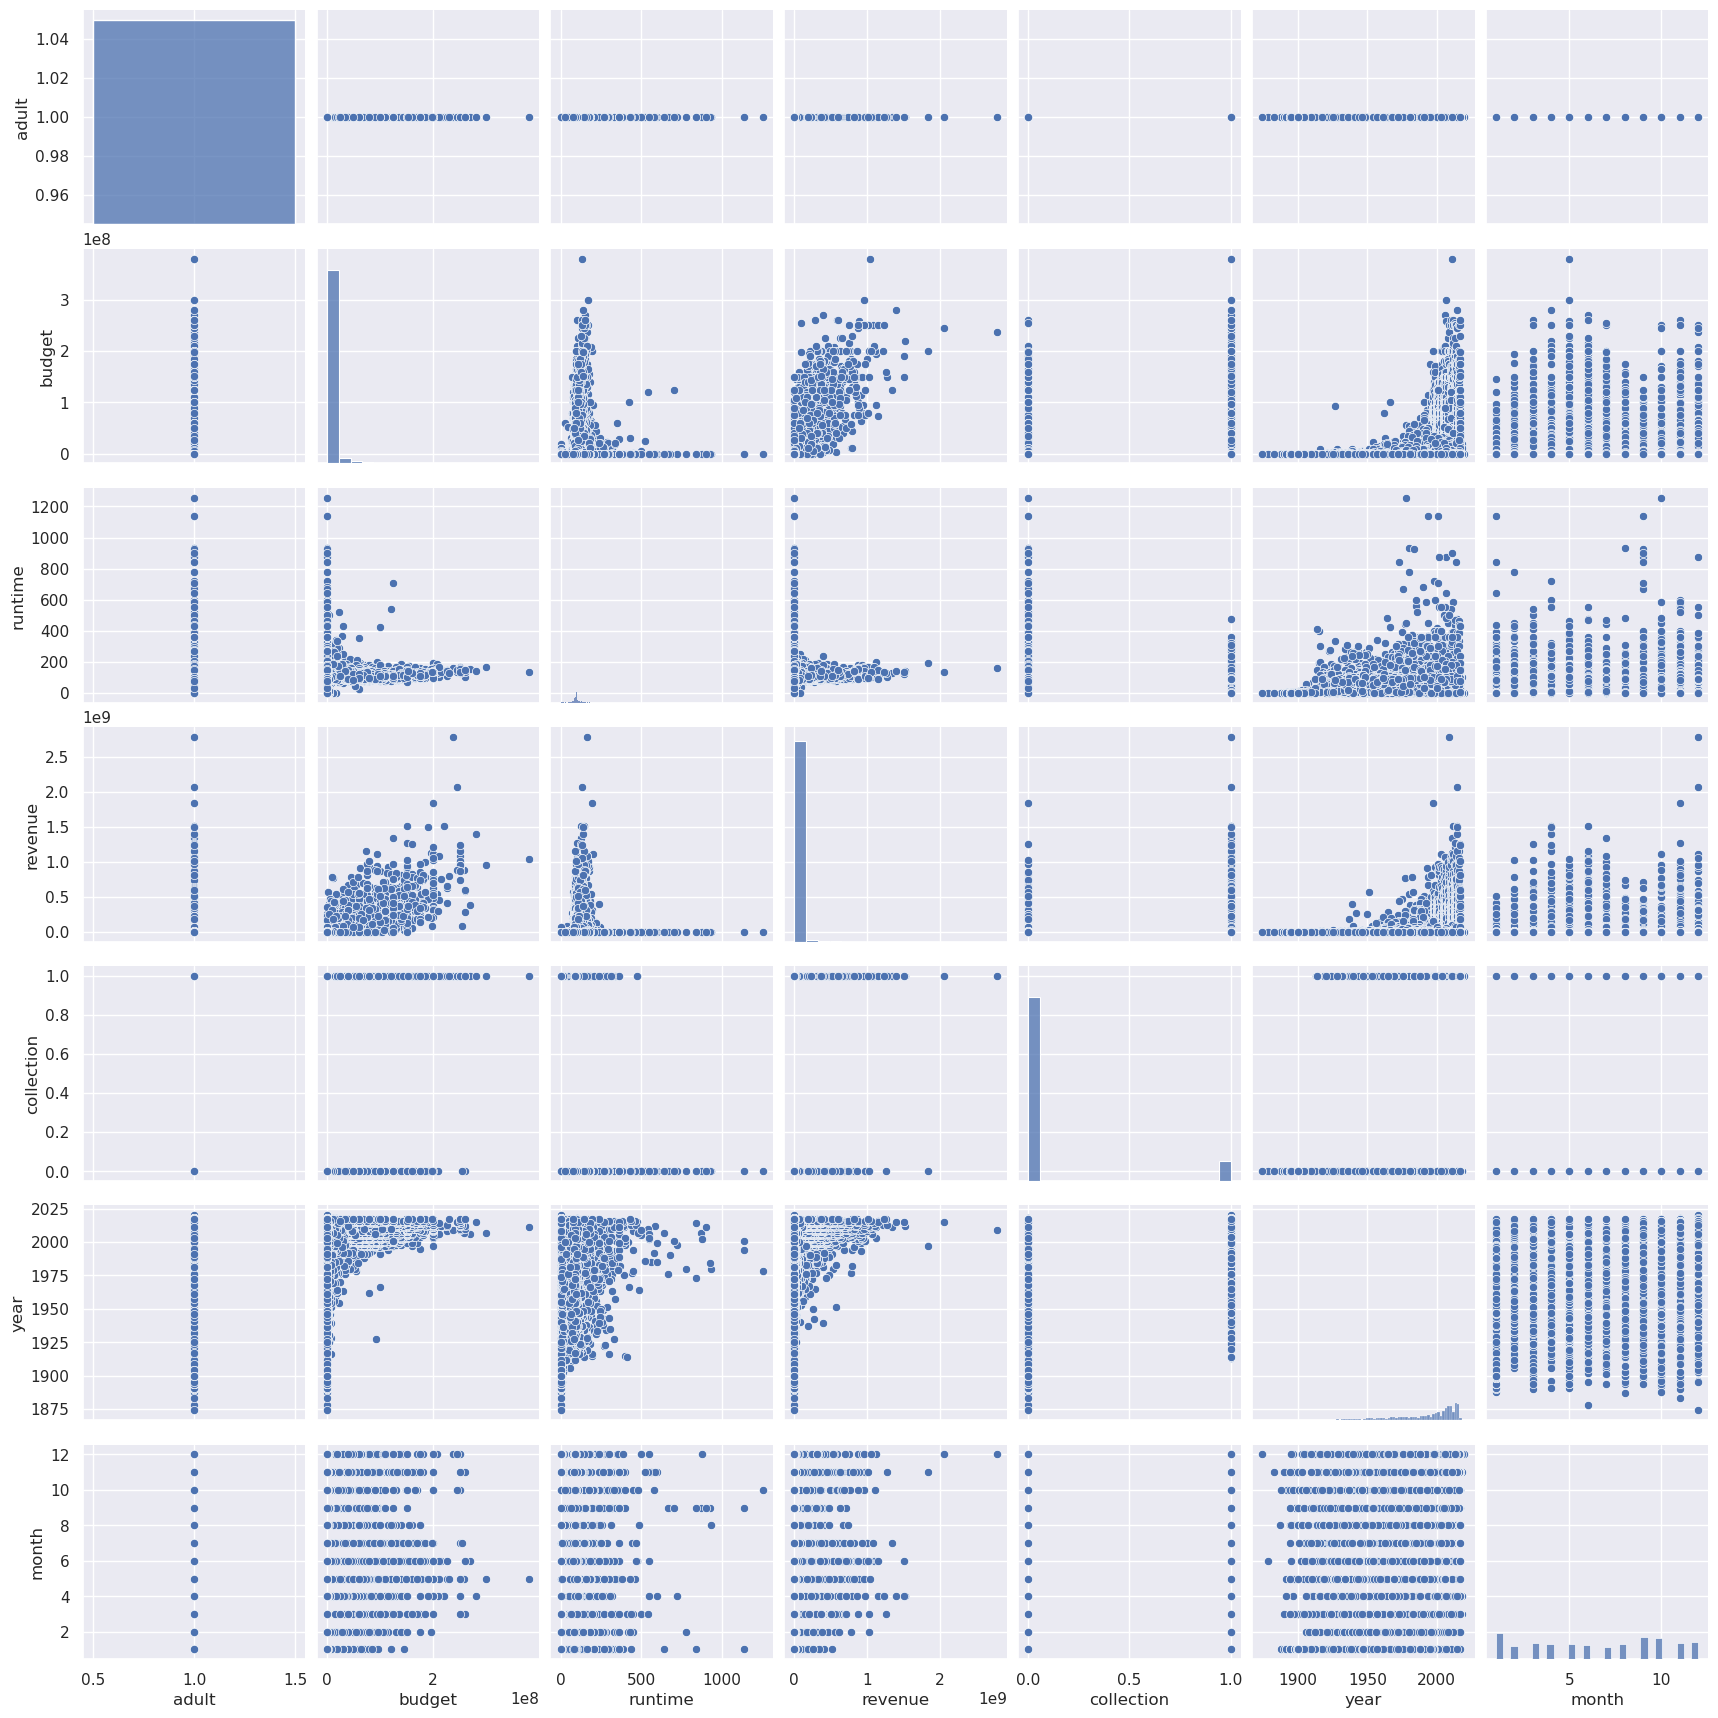

In [23]:
sns.pairplot(movies_df)

<Axes: >

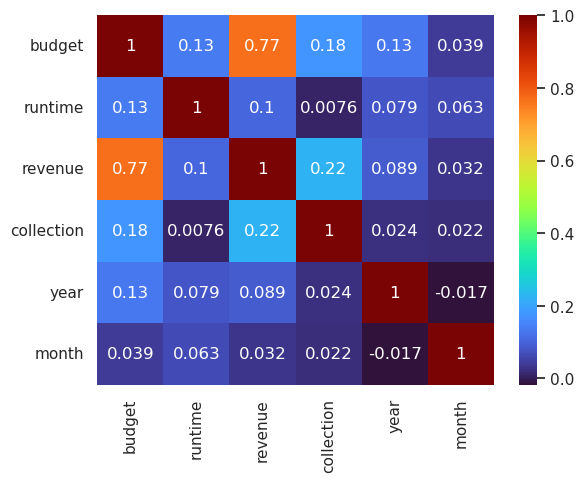

In [24]:
corr = movies_df[['budget','runtime','revenue','collection','year','month']].corr()
sns.heatmap(corr, annot=True, cmap='turbo',)

We find that budget and revenue are more closely related than perhaps expected, whereas all other categories don't show significant correlation. This leads us to think that a very simple linear regression might already yield some results. Later it would be interesting to see if more complex models can capitalize on some of the categorical variables ...

In [25]:
movies_df.head()

,id,adult,budget,runtime,status,revenue,collection,genre_name,prod_comp_names,lang,year,month
0,862,1,30000000,81,Released,373554033,1,"[Animation, Comedy, Family]",[Pixar Animation Studios],[en],1995,10
1,8844,1,65000000,104,Released,262797249,0,"[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...","[en, fr]",1995,12
2,15602,1,0,101,Released,0,1,"[Romance, Comedy]","[Warner Bros., Lancaster Gate]",[en],1995,12
3,31357,1,16000000,127,Released,81452156,0,"[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],[en],1995,12
4,11862,1,0,106,Released,76578911,1,[Comedy],"[Sandollar Productions, Touchstone Pictures]",[en],1995,2


# Dummies

In [26]:
movies_df2 = movies_df.copy()

In [27]:
dummy_columns = ['genre_name','prod_comp_names','lang']

In [28]:
unique_genres = list(set([x for list in movies_df2['genre_name'] for x in list]))
unique_prod_comps = list(set([x for list in movies_df2['prod_comp_names'] for x in list]))
unique_langs = list(set([x for list in movies_df2['lang'] for x in list]))

In [29]:
movies_df2 = movies_df2.join(movies_df2['genre_name'].str.join('|').str.get_dummies().add_prefix('genre_'))
# movies_df2 = movies_df2.join(movies_df2['prod_comp_names'].str.join('|').str.get_dummies().add_prefix('prod'))
movies_df2 = movies_df2.join(movies_df2['lang'].str.join('|').str.get_dummies().add_prefix('lang_'))
#movies_df2 = movies_df2.join(movies_df2['cast_list'].str.join('|').str.get_dummies().add_prefix('cast_'))
movies_df2.head()

,id,adult,budget,runtime,status,revenue,collection,genre_name,prod_comp_names,lang,...,lang_uk,lang_ur,lang_uz,lang_vi,lang_wo,lang_xh,lang_xx,lang_yi,lang_zh,lang_zu
0,862,1,30000000,81,Released,373554033,1,"[Animation, Comedy, Family]",[Pixar Animation Studios],[en],...,0,0,0,0,0,0,0,0,0,0
1,8844,1,65000000,104,Released,262797249,0,"[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...","[en, fr]",...,0,0,0,0,0,0,0,0,0,0
2,15602,1,0,101,Released,0,1,"[Romance, Comedy]","[Warner Bros., Lancaster Gate]",[en],...,0,0,0,0,0,0,0,0,0,0
3,31357,1,16000000,127,Released,81452156,0,"[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],[en],...,0,0,0,0,0,0,0,0,0,0
4,11862,1,0,106,Released,76578911,1,[Comedy],"[Sandollar Productions, Touchstone Pictures]",[en],...,0,0,0,0,0,0,0,0,0,0


In [30]:
movies_df2 = movies_df2.drop(['id','status','genre_name','lang','prod_comp_names'],axis=1)

In [31]:
genre_columns = ['genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime',
       'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy',
       'genre_Foreign', 'genre_History', 'genre_Horror', 'genre_Music',
       'genre_Mystery', 'genre_Romance', 'genre_Science Fiction',
       'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western']

<Axes: title={'center': 'Average revenue by genre'}>

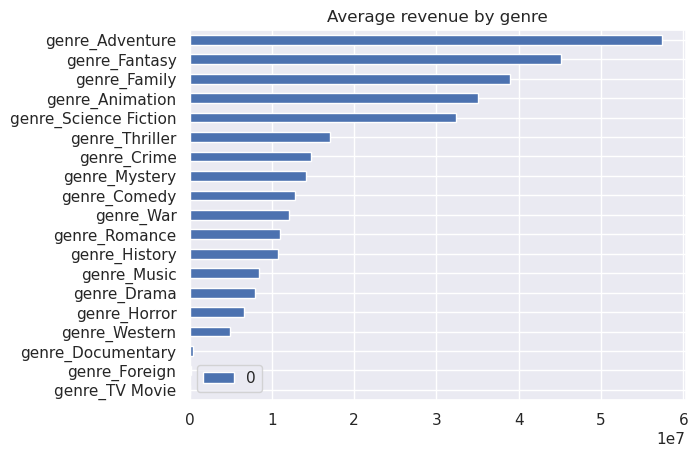

In [32]:
genre_dict = {}

for genre in genre_columns:
    genre_dict[genre] = movies_df2[movies_df2[genre] == 1]['revenue'].mean()
    
pd.DataFrame(data=genre_dict,index=[0]).T.sort_values(by=0,ascending=True).plot.barh(title='Average revenue by genre')

# First try: A linear regression

In [33]:
linreg_df = movies_df2[['budget','runtime','revenue','year','month']].copy()

X = linreg_df.drop(['revenue'],axis=1)
y = linreg_df['revenue']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size = 0.75,
                                                    random_state=12,
                                                    shuffle=True)

In [34]:
reg = LinearRegression()
reg.fit(X_train,y_train)
r2 = reg.score(X_test,y_test)
print(f"Score: {r2}")
print(f"{np.round(r2 * 100,2)} %")

Score: 0.5905533715542766
59.06 %


Using a simple linear regression, we achieve just below 60% accuracy.

In [35]:
y_preds = reg.predict(X_test)
reg_mse = mean_squared_error(y_test,y_preds)
reg_rmse = np.sqrt(reg_mse)
reg_rmse

36205976.52978424

Or, in real numbers, a root mean squared error of 36 million. No executive is going to be very happy with those predictions.

<Axes: ylabel='Frequency'>

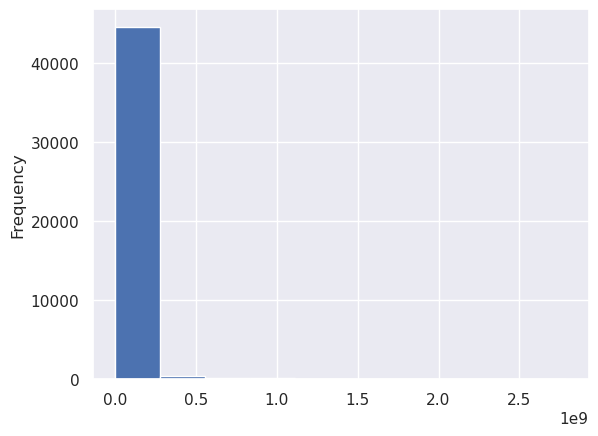

In [36]:
movies_df['revenue'].plot.hist()

Interestingly, we can see that almost all movies have very low revenue. This might open us up later to do a classification instead. So we won't predict revenue, but perhaps we have a shot at predicting if the movie will break even.

# Decision Tree Regressor

In [37]:
X = movies_df2.drop(['revenue'],axis=1)
y = movies_df2['revenue']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=91,
                                                    shuffle=True)

In [38]:
tree = DecisionTreeRegressor(
    criterion='squared_error',
    max_depth=4)

In [39]:
tree.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=4)

In [40]:
tree.score(X_test,y_test)

0.6182980335687773

In [41]:
movies_preds = tree.predict(X_test)
tree_mse = mean_squared_error(y_test,movies_preds)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

40430016.63927724

We don't see any change. Root mean squared error is 40 million.

# Random Forest Regressor

In [42]:
forest_reg = RandomForestRegressor()

In [43]:
forest_reg.fit(X_train,y_train)
forest_reg.score(X_test,y_test)

0.6697763366385856

In [44]:
y_test_forest = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_test,y_test_forest)
forest_rmse = np.sqrt(forest_mse)

In [45]:
forest_rmse

37605019.385304555

In [46]:
param_grid = [
    {'n_estimators': [100,500,1500], 'max_features':[4,8]},
]

In [47]:
grid_search = GridSearchCV(
    estimator = forest_reg,
    param_grid = param_grid,
    scoring = "neg_mean_squared_error",
    cv = 3,
    return_train_score = True,
    verbose=10
)

In [48]:
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START max_features=4, n_estimators=100............................
[CV 1/3; 1/6] END max_features=4, n_estimators=100;, score=(train=-200675374497037.312, test=-1761153746621130.000) total time=   4.1s
[CV 2/3; 1/6] START max_features=4, n_estimators=100............................
[CV 2/3; 1/6] END max_features=4, n_estimators=100;, score=(train=-246506020694802.938, test=-1095750956492651.375) total time=   4.2s
[CV 3/3; 1/6] START max_features=4, n_estimators=100............................
[CV 3/3; 1/6] END max_features=4, n_estimators=100;, score=(train=-199807291057558.250, test=-1951814384497970.250) total time=   4.1s
[CV 1/3; 2/6] START max_features=4, n_estimators=500............................
[CV 1/3; 2/6] END max_features=4, n_estimators=500;, score=(train=-196025866119239.562, test=-1726528656509024.500) total time=  20.7s
[CV 2/3; 2/6] START max_features=4, n_estimators=500........................

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [4, 8],
                          'n_estimators': [100, 500, 1500]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=10)

In [49]:
best_params = grid_search.best_params_

In [50]:
np.sqrt(-grid_search.best_score_)

38540889.209415756

In [51]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

40036313.048746765 {'max_features': 4, 'n_estimators': 100}
39684818.41738657 {'max_features': 4, 'n_estimators': 500}
39775739.5604271 {'max_features': 4, 'n_estimators': 1500}
38756532.27480795 {'max_features': 8, 'n_estimators': 100}
38611004.608382754 {'max_features': 8, 'n_estimators': 500}
38540889.209415756 {'max_features': 8, 'n_estimators': 1500}


In [52]:
forest_cv = RandomForestRegressor(n_estimators=best_params['n_estimators'],max_features=best_params['max_features'])
forest_cv.fit(X_train,y_train)
forest_r2 = forest_cv.score(X_test,y_test)
print(f"Score for this random forest: {forest_r2}")

Score for this random forest: 0.6556391630937705


# Classifier

Given the difficulty predicting movie box office success accurately, perhaps the next best thing is to classify a movie by the ability to break even or not. In this case we will do a very simple calculation where we classify a movie as break even when the revenue outperforms the budget. In reality, this is more complicated due to the different ways in which movies are financed. In a real-life business case, this would have to be taken into account, considering equity and non-equity financing, but for this example we will go with the simple solution.

While it is not as satisfying than predicting an actual number with great accuracy, determining if we will make our money back is at least something executives might be interested in.

In [53]:
movies_df3 = movies_df2.copy()

In [54]:
movies_df3['profit'] = np.subtract(movies_df3['revenue'],movies_df3['budget'])
movies_df3['break_even'] = movies_df3['profit'].apply(lambda x: 1 if x > 0 else 0)
movies_df3.head(15)

,adult,budget,runtime,revenue,collection,year,month,genre_Action,genre_Adventure,genre_Animation,...,lang_uz,lang_vi,lang_wo,lang_xh,lang_xx,lang_yi,lang_zh,lang_zu,profit,break_even
0,1,30000000,81,373554033,1,1995,10,0,0,1,...,0,0,0,0,0,0,0,0,343554033,1
1,1,65000000,104,262797249,0,1995,12,0,1,0,...,0,0,0,0,0,0,0,0,197797249,1
2,1,0,101,0,1,1995,12,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,16000000,127,81452156,0,1995,12,0,0,0,...,0,0,0,0,0,0,0,0,65452156,1
4,1,0,106,76578911,1,1995,2,0,0,0,...,0,0,0,0,0,0,0,0,76578911,1
5,1,60000000,170,187436818,0,1995,12,1,0,0,...,0,0,0,0,0,0,0,0,127436818,1
6,1,58000000,127,0,0,1995,12,0,0,0,...,0,0,0,0,0,0,0,0,-58000000,0
7,1,0,97,0,0,1995,12,1,1,0,...,0,0,0,0,0,0,0,0,0,0
8,1,35000000,106,64350171,0,1995,12,1,1,0,...,0,0,0,0,0,0,0,0,29350171,1
9,1,58000000,130,352194034,1,1995,11,1,1,0,...,0,0,0,0,0,0,0,0,294194034,1


In [55]:
X = movies_df3.drop(['revenue','profit','break_even'],axis=1)
y = movies_df3['break_even']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75,random_state=90,shuffle=True)

treec = DecisionTreeClassifier()
treec.fit(X_train,y_train)
treec.score(X_test,y_test)

0.8442411863955244

In [56]:
feature_importances = treec.fit(X_train,y_train).feature_importances_

In [57]:
feature_imp = pd.DataFrame()
feature_imp['feature_importances'] = feature_importances
feature_imp = feature_imp.set_index(X_train.columns)
feature_imp.sort_values(by='feature_importances',ascending=False).head(10)

,feature_importances
budget,0.304209
year,0.159300
runtime,0.150015
month,0.096535
collection,0.023884
genre_Comedy,0.014147
genre_Action,0.014029
genre_Drama,0.013719
genre_Thriller,0.013516
genre_Crime,0.012746


<Axes: >

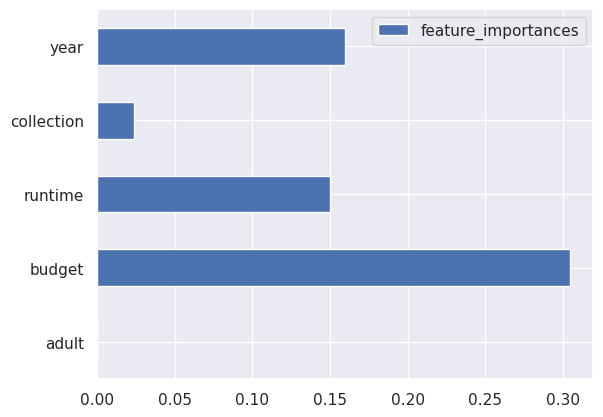

In [58]:
feature_imp.head().plot.barh()

# Conclusion
It seems the nobody knows principle is alive and well. Even with machine learning techniques and big data available, predictions struggle to become meaningful enough to make clear business decisions. This seems to be supported by academic literature on the topic. For example, in their paper **A Machine Learning Approach to Predict Movie Box-Office Success** [1], using only pre-release features, the authors' neural network achieves only 68% accuracy.

## Results
My own modeling proved similar results:

|Model|R²|
|-|-|
|Linear Regression|0.59|
|Decision Tree Regressor|0.61|
|Random Forest Regressor|0.65|
|Decision Tree Classifier|0.84|

Predicting the exact revenue of a movie based on pre-release features was possible to about 65% accuracy and a RMSE of ~40m.
Not unexpectedly, classifying the movies simply by break-even or not was more successful at 84%, but naturally much less helpful in determining movie success.

### Correlation vs Causation
Looking at the correlation between features, we can quickly understand why our models underperform:
* Highest correlation is **Budget**, but higher budgeted movies tend to be blockbusters with big releases and big marketing spend, so this is to be expected. Perhaps it's surprising that the correlation is as high as it is.
* Next we have **Collection**, which makes sense because only movies successful enough to get a sequel end up in this category. Could be interesting to compare average revenue of first installments and their respective sequels.
* After that, **Year**, but since **Budget** is increasing over time and we see a high correlation here, this is to be expected as well.
* **Runtime** plays a role as well, but p-values quickly fades into the single digits after that.

## Limitations
- When looking at break-even, I simply subtracted budget and revenue from each other. In reality, this calculation is much more complicated and takes into account equity and non-equity funding, marketing spend as well as the long tail with various VOD and disk releases. However, I still wanted to give it a try with the data available.
- More features are technically available, such as the cast and the production companies, which could easily improve the results. However, recreating these features as one-hot-encoded dummies broke the memory limitations of this notebook. It would be very interesting to take into account the **star power** of any given actor by looking at this actor's filmographic revenue in isolation. While this would introduce multicolinearity, it is a feature we would feasably have available to us and should use it.
- I attempted to replicate the **star power** index from the below cited paper [1], however, calculating the aggregated amounts for all movies would have taken 6 to 8 hours and was again beyond the notebook's capacity.

Source:
1. https://dspace.bracu.ac.bd/xmlui/bitstream/handle/10361/9015/13301028,13301019_CSE.pdf?sequence=1